In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.4 GB  | Proc size: 156.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
!kill -9 -1

In [0]:
!test ! -f BrainMRISegmentation.zip && wget "https://storage.googleapis.com/kaggle-data-sets/181273/407317/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1574053355&Signature=GX%2BYJoWuKraKxclaEk80prMCLTDlaDrdSSdMrRe3zgbR%2FaPF2Op7Z5P8OZeN1RGZwSX%2FbgvJFG6LbQehVMXAoqhdzs2VUod3Pd0wlyp%2BjC10do8H7%2B6WDkhROKhR9qj1vjwwT2LqLMR3XDiJUlq1ipm5kqm15UeLi1gbjM3zsXkKLFxP6hNbk8FUmoswA1MdLB8OxIVjWzsUNYFBfGqaQoa37vM4Z2GhQ0qZeYHqTC9kJG4QyWE8MTQuIrp%2BdI5ofrSoYFmpnibsyWtxWty70R8TApMO0uU%2BkXHYhlH%2FMgVZyngk0he3r%2B%2FqDR2xE6LTgfqdkPl%2FagHPjo%2FxHFeC7g%3D%3D&response-content-disposition=attachment%3B+filename%3Dlgg-mri-segmentation.zip" -O BrainMRISegmentation.zip

--2019-11-15 05:03:18--  https://storage.googleapis.com/kaggle-data-sets/181273/407317/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1574053355&Signature=GX%2BYJoWuKraKxclaEk80prMCLTDlaDrdSSdMrRe3zgbR%2FaPF2Op7Z5P8OZeN1RGZwSX%2FbgvJFG6LbQehVMXAoqhdzs2VUod3Pd0wlyp%2BjC10do8H7%2B6WDkhROKhR9qj1vjwwT2LqLMR3XDiJUlq1ipm5kqm15UeLi1gbjM3zsXkKLFxP6hNbk8FUmoswA1MdLB8OxIVjWzsUNYFBfGqaQoa37vM4Z2GhQ0qZeYHqTC9kJG4QyWE8MTQuIrp%2BdI5ofrSoYFmpnibsyWtxWty70R8TApMO0uU%2BkXHYhlH%2FMgVZyngk0he3r%2B%2FqDR2xE6LTgfqdkPl%2FagHPjo%2FxHFeC7g%3D%3D&response-content-disposition=attachment%3B+filename%3Dlgg-mri-segmentation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748584920 (714M) [application/zip]
Saving to: ‘BrainMRISegmentation.zip’

BrainMRISegmentatio 100%

In [0]:
!test ! -d kaggle_3m && unzip -qq BrainMRISegmentation.zip

In [ ]:
from glob import glob
from skimage.io import imread, imsave
labels = glob('kaggle_3m/*/*_mask.tif')
for label in labels:
  img=imread(label)
  img[img==255]=1
  imsave(label.split('.')[-2]+'_encoded.'+label.split('.')[-1], img)

In [0]:
from fastai import *
from fastai.vision import *
np.random.seed(23)
torch.manual_seed(23)

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = (target != 0)
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def dice_coeff(input, target):
  target = target.squeeze(1)
  input=input.argmax(dim=1)
  num=(2*input*target).sum()+1.0
  den=input.sum()+target.sum()+1.0
  return num.float()/den.float()

In [0]:
defaults.device = torch.device('cuda')

In [0]:
src=SegmentationItemList.from_folder('kaggle_3m')

In [0]:
src.items = np.array(list(filter(lambda x : '_mask' not in str(x), src.items)))

In [0]:
valid_patients = list(filter(lambda x:x.startswith('TCGA_'),os.listdir('kaggle_3m')))
valid_patients = np.random.choice(valid_patients, 10, replace=False)

In [0]:
src = src.split_by_valid_func(lambda x: (str(x).split('/')[-2] in valid_patients))

In [0]:
codes=['Background', 'Tumour']
src = src.label_from_func(lambda x:str(x)[:-4]+'_mask_encoded'+str(x)[-4:], classes=codes)

In [0]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_rotate=15), tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [0]:
metrics = dice_coeff
wd=1e-2

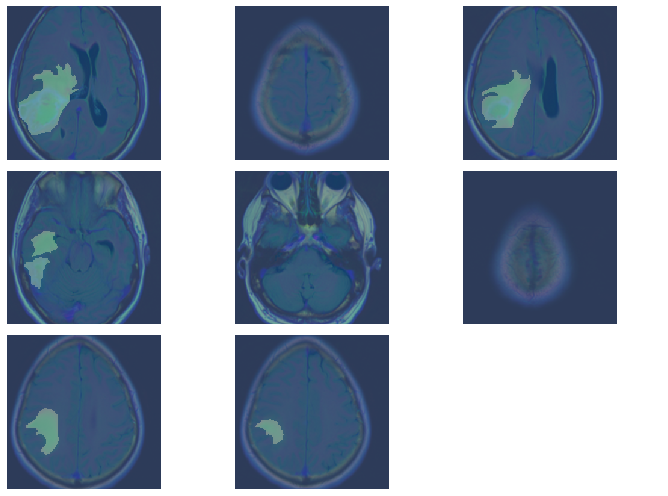

In [0]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


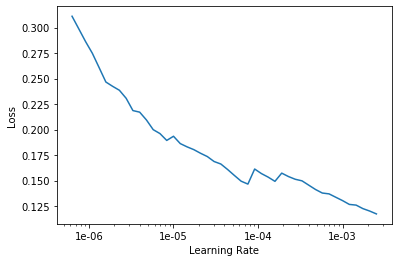

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(4e-5))

epoch,train_loss,valid_loss,dice_coeff,time
0,0.018116,0.033948,0.455899,09:45
1,0.013863,0.014975,0.750624,09:41
2,0.011420,0.011987,0.781080,09:39
3,0.009025,0.016134,0.747039,09:39
4,0.006643,0.010016,0.842430,09:39
5,0.006338,0.009915,0.860489,09:39
6,0.006042,0.009711,0.863432,09:39


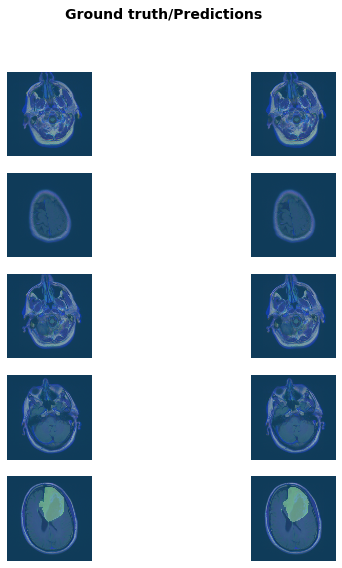

In [0]:
learn.show_results(rows=5, figsize=(8,9))

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (3519 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: kaggle_3m;

Valid: LabelList (410 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: kaggle_3m;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(k

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


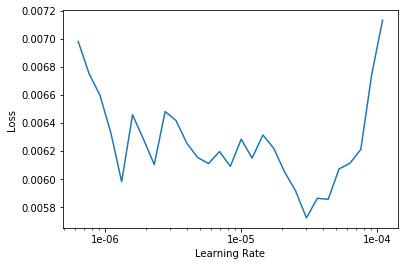

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.validate()

[0.009710669, tensor(0.8634)]

In [0]:
lrs = slice(5e-7/400,5e-7/4)

In [0]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice_coeff,time
0,0.005989,0.009821,0.856792,09:49
1,0.005924,0.009454,0.863728,09:49
2,0.005976,0.009408,0.865622,09:49
3,0.005921,0.009272,0.862654,09:49
4,0.006505,0.009407,0.863967,09:49
5,0.005943,0.009371,0.865542,09:49
6,0.006073,0.009028,0.867126,09:49
7,0.006626,0.009020,0.865792,09:49
8,0.005910,0.009124,0.867154,09:49
9,0.006377,0.009545,0.864900,09:49


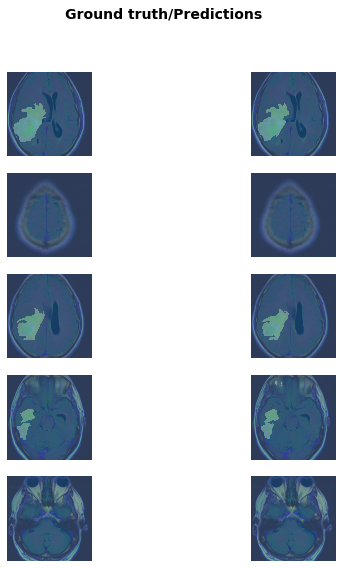

In [0]:
learn.show_results(rows=5, figsize=(8,9))

In [0]:
# Import required packages:
import cv2
from glob import glob
from skimage.io import imread
def draw_boundary(image, mask, color):
  # Apply cv2.threshold() to get a binary image
  image=image.copy()
  ret, thresh = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
  im, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(image, contours, 0, color, 2)
  return image

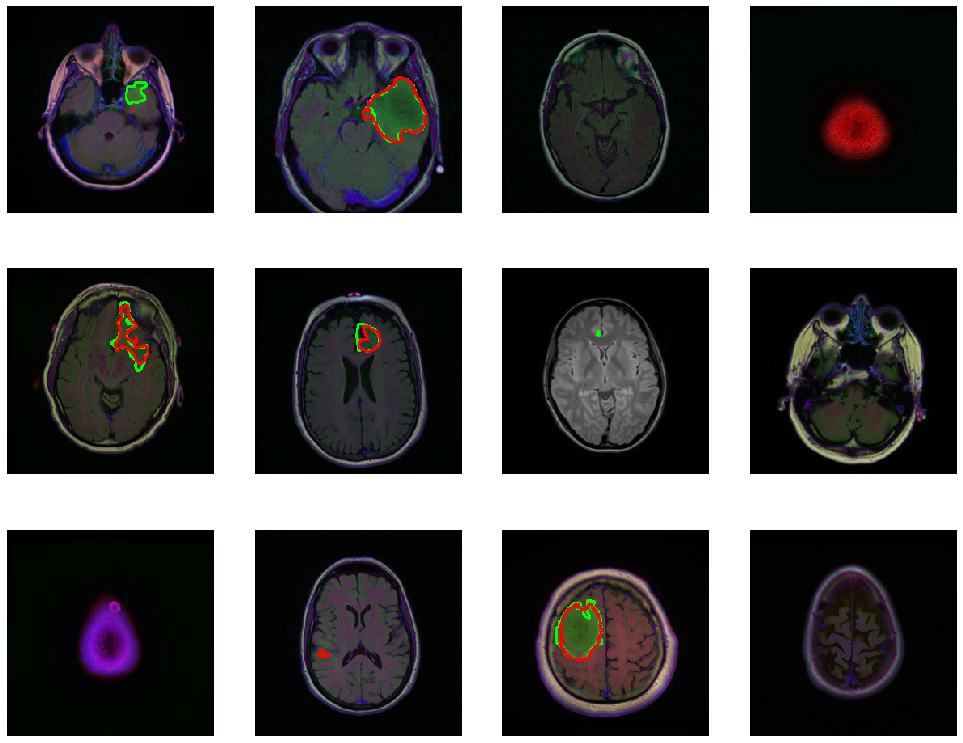

In [0]:
images=list(filter(lambda x:'mask' not in x, glob('kaggle_3m/*/*.tif')))
n_imgs=12
cols=4
rows=int(np.ceil(n_imgs/cols))
fig = plt.figure(figsize=(17., 14.), )
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
for i,img_path in enumerate(np.random.choice(images, n_imgs, replace=False)):
  img = imread(img_path)
  pred=open_image(img_path)
  mask = imread(img_path.split('.')[-2]+'_mask'+'.'+img_path.split('.')[-1], as_gray=True)
  pred=np.array(learn.predict(pred)[1].squeeze(0)).astype(np.uint8)*255
  img_show = draw_boundary(img, mask, (0, 255, 0))
  img_show = draw_boundary(img_show, pred, (255, 0, 0))
  plt.subplot(rows, cols, i+1).axis('off')
  plt.imshow(img_show)




In [0]:
learn.save('stage-1-unfreezed')

In [0]:
learn.save('/content/gdrive/My Drive/stage-1-unfreezed')